In [1]:
!pip install keras
!pip install tensorflow
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=ff5ca2c2c5dbbda552385cfbe8d4d8058b565acc019c395b84406908b954e844
  Stored in directory: /root/.cache/pip/wheels/15/0c/b3/674aea8c5d91c642c817d4d630bd58faa316724b136844094d
Successfully built utils


In [2]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tp
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
import itertools

from tensorflow.keras.utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

2025-06-15 06:00:56.842280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749967257.093142      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749967257.174584      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
import pandas as pd

REAL_PATH = '/kaggle/input/mid-dataset/datasets/train/original/'
FAKE_PATH = '/kaggle/input/mid-dataset/datasets/train/morphed/'

REAL = sorted(os.listdir(REAL_PATH))
FAKE = sorted(os.listdir(FAKE_PATH))

# Prepend correct subfolder path to each file
real_paths = [REAL_PATH + fname for fname in REAL]
fake_paths = [FAKE_PATH + fname for fname in FAKE]

# Labels
real_labels = [0] * len(real_paths)
fake_labels = [1] * len(fake_paths)

# Combine
all_paths = real_paths + fake_paths
all_labels = real_labels + fake_labels

# Make DataFrame
df = pd.DataFrame({'images': all_paths, 'labels': all_labels})
df.to_csv('/kaggle/working/dataset.csv', index=False)

print(df.head())


                                              images  labels
0  /kaggle/input/mid-dataset/datasets/train/origi...       0
1  /kaggle/input/mid-dataset/datasets/train/origi...       0
2  /kaggle/input/mid-dataset/datasets/train/origi...       0
3  /kaggle/input/mid-dataset/datasets/train/origi...       0
4  /kaggle/input/mid-dataset/datasets/train/origi...       0


In [5]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

In [6]:
from PIL import Image, ImageChops, ImageEnhance
import os

def convert_to_ela_image(path, quality):
    # Extract only the file name
    base_filename = os.path.basename(path).split('.')[0]
    
    # Use Kaggle's writable directory for temp files
    resaved_filename = f"/kaggle/working/{base_filename}.resaved.jpg"
    ELA_filename = f"/kaggle/working/{base_filename}.ela.png"
    
    # Open and resave the image
    im = Image.open(path).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    
    resaved_im = Image.open(resaved_filename)
    
    # Perform ELA
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
        
    scale = 255.0 / max_diff
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    # Optionally save the ELA image
    ela_im.save(ELA_filename)
    
    return ela_im


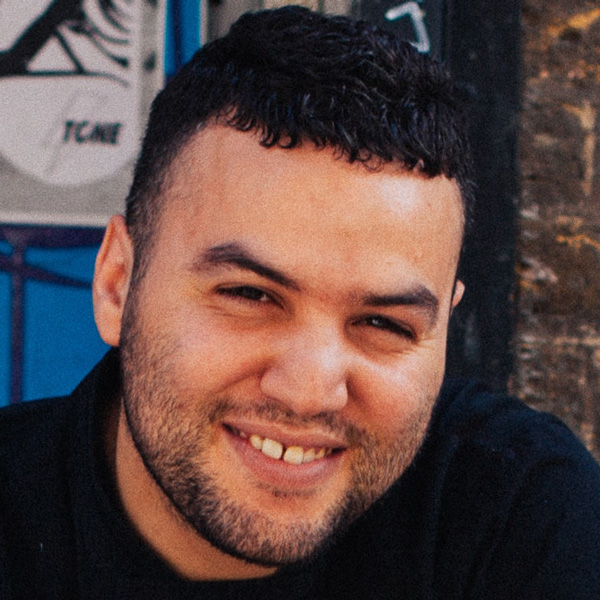

In [7]:
Image.open('/kaggle/input/mid-dataset/datasets/train/original/real_00004.jpg')

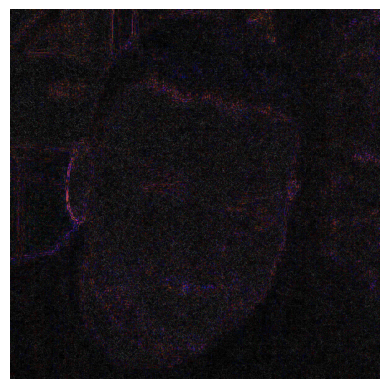

In [8]:
ela_img = convert_to_ela_image('/kaggle/input/mid-dataset/datasets/train/original/real_00004.jpg', 90)
import matplotlib.pyplot as plt
plt.imshow(ela_img)
plt.axis('off')
plt.show()


In [9]:
dataset = pd.read_csv('/kaggle/working/dataset.csv')
print(dataset)

                                                 images  labels
0     /kaggle/input/mid-dataset/datasets/train/origi...       0
1     /kaggle/input/mid-dataset/datasets/train/origi...       0
2     /kaggle/input/mid-dataset/datasets/train/origi...       0
3     /kaggle/input/mid-dataset/datasets/train/origi...       0
4     /kaggle/input/mid-dataset/datasets/train/origi...       0
...                                                 ...     ...
2036  /kaggle/input/mid-dataset/datasets/train/morph...       1
2037  /kaggle/input/mid-dataset/datasets/train/morph...       1
2038  /kaggle/input/mid-dataset/datasets/train/morph...       1
2039  /kaggle/input/mid-dataset/datasets/train/morph...       1
2040  /kaggle/input/mid-dataset/datasets/train/morph...       1

[2041 rows x 2 columns]


In [10]:
X = []
Y = []

In [11]:
for index, row in df.iterrows():
    image_path = row['images']
    label = row['labels']
    
    ela_image = convert_to_ela_image(image_path, 90).resize((128, 128))
    X.append(array(ela_image).flatten() / 255.0)
    Y.append(label)


In [12]:
X

[array([0.05098039, 0.0627451 , 0.20784314, ..., 0.04313725, 0.04705882,
        0.05882353]),
 array([0.        , 0.        , 0.        , ..., 0.03137255, 0.02352941,
        0.03921569]),
 array([0.03137255, 0.02745098, 0.02352941, ..., 0.05098039, 0.05098039,
        0.05490196]),
 array([0.07058824, 0.05882353, 0.05490196, ..., 0.04705882, 0.03921569,
        0.05490196]),
 array([0.10588235, 0.10588235, 0.10980392, ..., 0.09411765, 0.09411765,
        0.09411765]),
 array([0.03137255, 0.02352941, 0.04705882, ..., 0.04313725, 0.03137255,
        0.03137255]),
 array([0.05098039, 0.03921569, 0.04313725, ..., 0.03921569, 0.04313725,
        0.04705882]),
 array([0.06666667, 0.06666667, 0.06666667, ..., 0.07058824, 0.07058824,
        0.06666667]),
 array([0.01176471, 0.00784314, 0.01176471, ..., 0.00784314, 0.00784314,
        0.00784314]),
 array([0.0745098 , 0.04705882, 0.06666667, ..., 0.0627451 , 0.05490196,
        0.0627451 ]),
 array([0.05882353, 0.04705882, 0.05490196, ..., 0

In [13]:
X = X.reshape(-1, 128, 128, 3)

AttributeError: 'list' object has no attribute 'reshape'

In [ ]:
from PIL import Image, ImageChops, ImageEnhance
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

np.random.seed(2)

# Dataset Paths
REAL_PATH = '/kaggle/input/mid-dataset/datasets/train/original/'
FAKE_PATH = '/kaggle/input/mid-dataset/datasets/train/morphed/'

REAL = sorted(os.listdir(REAL_PATH))
FAKE = sorted(os.listdir(FAKE_PATH))

real_paths = [REAL_PATH + fname for fname in REAL]
fake_paths = [FAKE_PATH + fname for fname in FAKE]
real_labels = [0] * len(real_paths)
fake_labels = [1] * len(fake_paths)

all_paths = real_paths + fake_paths
all_labels = real_labels + fake_labels

df = pd.DataFrame({'images': all_paths, 'labels': all_labels})
df.to_csv('/kaggle/working/dataset.csv', index=False)
print("Dataset preview:\n", df.head())

def convert_to_ela_image(path, quality=90):
    base_filename = os.path.basename(path).split('.')[0]
    resaved_filename = f"/kaggle/working/{base_filename}.resaved.jpg"
    ela_filename = f"/kaggle/working/{base_filename}.ela.png"

    im = Image.open(path).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    ela_im = ImageChops.difference(im, resaved_im)

    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema]) or 1
    scale = 255.0 / max_diff
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    ela_im.save(ela_filename)
    return ela_im

# Visualize a sample image
sample_image = convert_to_ela_image(real_paths[0])
plt.imshow(sample_image)
plt.axis('off')
plt.title("Sample ELA Image")
plt.show()

X, Y = [], []
for index, row in df.iterrows():
    image_path = row['images']
    label = row['labels']
    ela_image = convert_to_ela_image(image_path, 90).resize((128, 128))
    X.append(np.array(ela_image) / 255.0)
    Y.append(label)

X = np.array(X).reshape(-1, 128, 128, 3)
Y = to_categorical(Y, num_classes=2)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=5)

model = Sequential()
model.add(Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (5, 5), padding='valid', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

optimizer = RMSprop(learning_rate=0.0005, rho=0.9, epsilon=1e-08)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

history = model.fit(X_train, Y_train, batch_size=100, epochs=9,
                    validation_data=(X_val, Y_val), verbose=2,
                    callbacks=[early_stopping])
model.save("/kaggle/working/fake_image_model.h5")


# Plot training history
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(history.history['loss'], 'b', label="Training Loss")
ax[0].plot(history.history['val_loss'], 'r', label="Validation Loss")
ax[0].legend(loc='upper right')
ax[0].set_title("Loss")

ax[1].plot(history.history['accuracy'], 'b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], 'r', label="Validation Accuracy")
ax[1].legend(loc='upper left')
ax[1].set_title("Accuracy")

plt.tight_layout()
plt.show()
